## Imports of libraries and data

In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

# # Imports for Pycox

# # For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

# import pycox as pc
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

In [42]:
interval_and_weather_merged = pd.read_csv('./interval_and_weather_merged.csv')
interval_and_weather_merged_reyna = pd.read_csv('./reyna_interval_and_weather_merge.csv')
df_list = [interval_and_weather_merged, interval_and_weather_merged_reyna ]
print(interval_and_weather_merged.shape)
print(interval_and_weather_merged_reyna.shape)
interval_and_weather_merged = pd.concat(df_list)

# interval_and_weather_merged

(298, 21)
(46, 21)


In [43]:
# Data Cleanup including Removing American Aster
interval_and_weather_merged = interval_and_weather_merged[(interval_and_weather_merged['sheet_title'] != '10-14-2022 i11 American Aster') & (interval_and_weather_merged['sheet_title'] != '10-14-2022 i8 American Aster')]

# Add status to the dataframe
interval_and_weather_merged = interval_and_weather_merged.assign(status=1)

# Convert to seconds for the interval
interval_and_weather_merged['interval'] = interval_and_weather_merged['interval'] / 1000000000

,Unnamed: 0,endtime,starttime,interval,departing_insect,arriving_insect,sheet_title,timestamp_pd,timestamp_pd_rounded,same_insect,...,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,status
23,36,0 days 13:56:01,0 days 13:56:02,1.0,Apis mellifera,Bombus,09-28-2022 i4 New England Aster,2022-09-13 13:56:01,2022-09-13 14:00:00,0,...,69.0,0.0,NaN,290.0,13.0,NaN,1012.0,NaN,3.0,1
27,40,0 days 13:56:54,0 days 13:56:58,4.0,Apis mellifera,Bombus impatiens,09-28-2022 i4 New England Aster,2022-09-13 13:56:54,2022-09-13 14:00:00,0,...,69.0,0.0,NaN,290.0,13.0,NaN,1012.0,NaN,3.0,1
42,142,0 days 00:15:06,0 days 00:15:11,5.0,X. virginica (F),X. virginica (F),(pol.) +Physostegia virginiana 9.13.22,2022-09-13 14:50:19,2022-09-13 15:00:00,1,...,65.0,0.0,NaN,310.0,11.2,NaN,1012.0,NaN,3.0,1
69,160,0 days 00:58:57,0 days 00:59:02,5.0,X. virginica (F),Hemaris diffinis,(pol.) +Physostegia virginiana 9.13.22,2022-09-13 15:34:03,2022-09-13 16:00:00,0,...,61.0,0.0,NaN,280.0,13.0,NaN,1011.0,NaN,3.0,1
70,161,0 days 00:59:04,0 days 00:59:09,5.0,Hemaris diffinis,Augochlorini,(pol.) +Physostegia virginiana 9.13.22,2022-09-13 15:34:25,2022-09-13 16:00:00,0,...,61.0,0.0,NaN,280.0,13.0,NaN,1011.0,NaN,3.0,1
275,245,0 days 00:30:40,0 days 00:30:45,5.0,B. impatiens (F),B. impatiens (F),(pol.) +P2 Echinacea purpurea 10.6.22,2022-10-06 16:28:31,2022-10-06 16:00:00,1,...,41.0,0.0,NaN,260.0,7.0,NaN,1017.0,NaN,3.0,1
296,274,0 days 00:10:36,0 days 00:10:39,3.0,Lasioglossum (Dialictus) sp. (F),L. (Dialictus) sp. (F),(pol.) +Tithonia rotundifolia 10.14.22,2022-10-14 13:29:06,2022-10-14 13:00:00,1,...,100.0,0.0,NaN,210.0,6.0,NaN,1016.0,NaN,3.0,1


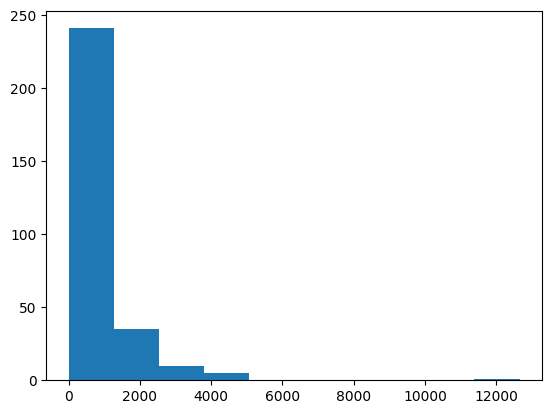

In [44]:
# Plot the distribution of the intervals
plt.hist(interval_and_weather_merged['interval'])

interval_and_weather_merged_greater_than_6000 = interval_and_weather_merged[(interval_and_weather_merged['interval'] <= 5)]
interval_and_weather_merged_greater_than_6000

## Initial Cox Regression

In [45]:
interval_and_weather_merged.iloc[0]
# 2 minutes and 13 + 17 seconds = 30
# 150 seconds
# interval_and_weather_merged['interval'] = interval_and_weather_merged['interval'] / 1000000000

interval_and_weather_merged.iloc[0]


Unnamed: 0                                  0
endtime                       0 days 11:41:43
starttime                     0 days 11:44:13
interval                                150.0
departing_insect                      Insecta
arriving_insect                       Insecta
sheet_title             07-28-2022 i10 Zinnia
timestamp_pd              2022-07-28 11:41:43
timestamp_pd_rounded      2022-07-28 12:00:00
same_insect                                 1
temp                                     23.0
dwpt                                     23.0
rhum                                    100.0
prcp                                      0.0
snow                                      NaN
wdir                                    270.0
wspd                                      7.2
wpgt                                      NaN
pres                                   1014.0
tsun                                      NaN
coco                                      3.0
status                            

In [46]:
interval_and_weather_merged['interval']

0      150.0
1     1170.0
2      660.0
3      124.0
4       31.0
       ...  
41    3121.0
42      90.0
43    4411.0
44     600.0
45     839.0
Name: interval, Length: 292, dtype: float64

In [17]:
# Interval column is in nanoseconds
interval_cut_off = 1*60*1000*1000000
df_less_than_interval = interval_and_weather_merged[(interval_and_weather_merged['interval'] < interval_cut_off) & (interval_and_weather_merged['same_insect'] == True)]

df_minus_short_interval_same_insect = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= interval_cut_off) | (interval_and_weather_merged['same_insect'] == False)]
# df_minus_short_interval_same_insect

In [47]:
def run_cox_regression_on_all_data(interval_and_weather_merged):
  # JCB: List of ones to represent that all intervals have completed
  status = np.ones(interval_and_weather_merged.shape[0])

  mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                  interval_and_weather_merged, status=status, ties="efron")
  rslt = mod.fit()
  print(rslt.summary())
  
run_cox_regression_on_all_data(interval_and_weather_merged)

status = np.ones(interval_and_weather_merged.shape[0])
interval_and_weather_merged['status'] = status
# 

                         Results: PHReg
Model:                      PH Reg         Sample size:       292
Dependent variable:         interval       Num. events:       292
Ties:                       Efron                                
-----------------------------------------------------------------
             log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
same_insect  0.3329    0.1303 1.3950  2.5560 0.0106 1.0807 1.8008
temp         0.0472    0.0258 1.0483  1.8301 0.0672 0.9967 1.1027
wspd         0.0157    0.0145 1.0158  1.0855 0.2777 0.9874 1.0450
dwpt        -0.0950    0.0196 0.9093 -4.8518 0.0000 0.8751 0.9449
coco         0.3239    0.0577 1.3825  5.6186 0.0000 1.2348 1.5479
Confidence intervals are for the hazard ratios


In [19]:
rossi = load_rossi()

# same_insect + temp + wspd + dwpt + coco
cph = CoxPHFitter()

trimmed_df = interval_and_weather_merged[['interval','status', 'same_insect' , 'temp' , 'wspd' , 'dwpt' , 'coco']].copy()
trimmed_df = trimmed_df.reset_index(drop=True)
cph.fit(trimmed_df, 'interval', 'status')
# cph.print_summary(model="untransformed variables", decimals=3)
cph.check_assumptions(trimmed_df, p_value_threshold=0.05, show_plots=True)
# trimmed_df


Proportional hazard assumption looks okay.


[]

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/l

[[<Axes: xlabel='rank-transformed time\n(p=0.0007)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0009)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0068)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0063)'>]]

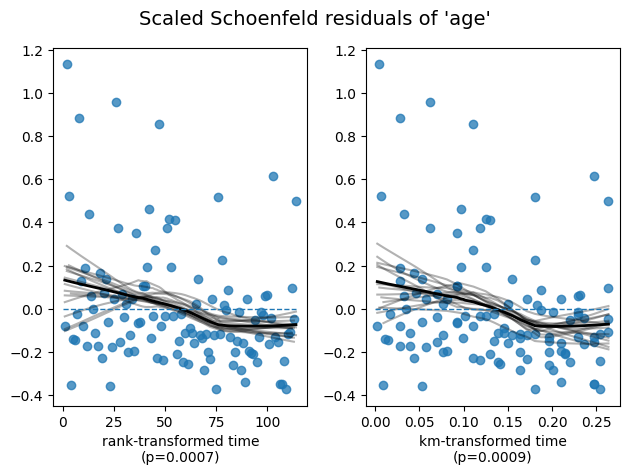

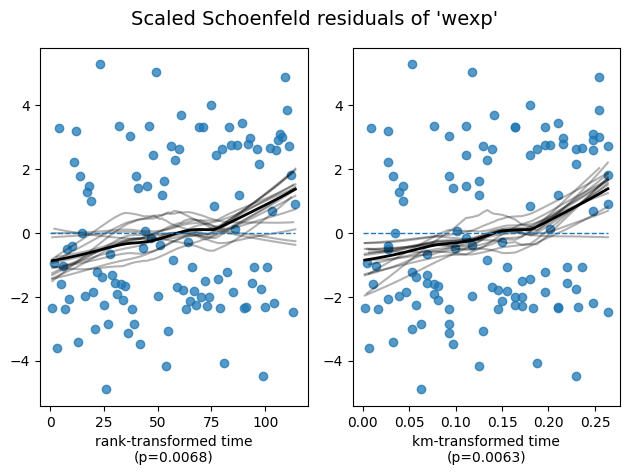

In [20]:
cph.fit(rossi, 'week', 'arrest')
cph.check_assumptions(rossi, p_value_threshold=0.05, show_plots=True)
# rossi

### Notes from Tom
Qualitative 

In [21]:
def run_bin_temp_analysis(df, binned_column, number_of_bins):
    # Find the range of the `temp` column
    temp_min = df[binned_column].min()
    temp_max = df[binned_column].max()

    print(f"Photo data {binned_column} range")
    print(temp_min)
    print(temp_max)

    # Calculate the range of each group based on the total range of `temp`
    group_range = (temp_max - temp_min) / 3
    print(group_range)
    # Create a new column in the DataFrame to hold the temperature group for each row
    df['binned_group'] = pd.cut(df[binned_column], bins=[temp_min, temp_min+group_range, temp_min+2*group_range, temp_max], labels=['Low', 'Medium', 'High'])

    # Print out the DataFrame grouped by temperature group
    for name, group in interval_and_weather_merged.groupby('binned_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        group_temp_range = f"{name}: {group['temp'].min()} - {group['temp'].max()}"
        print('group_temp_range', group_temp_range)

        status = np.ones(len(group))

        mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                        group, status=status, ties="efron")
        rslt = mod.fit()
        print(rslt.summary())
# df_minus_short_interval_same_insect

run_bin_temp_analysis(interval_and_weather_merged, 'temp', 3)

Photo data temp range
12.0
31.0
6.333333333333333
Group: Low

Number of rows in group: 80

group_temp_range Low: 14.0 - 18.0
                         Results: PHReg
Model:                     PH Reg          Sample size:        80
Dependent variable:        interval        Num. events:        80
Ties:                      Efron                                 
-----------------------------------------------------------------
             log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
same_insect -0.0800    0.3653 0.9231 -0.2191 0.8266 0.4512 1.8886
temp        -0.0498    0.1089 0.9514 -0.4578 0.6471 0.7686 1.1777
wspd         0.0155    0.0237 1.0156  0.6537 0.5133 0.9695 1.0638
dwpt        -0.1907    0.0548 0.8264 -3.4775 0.0005 0.7422 0.9202
coco         0.4602    0.1262 1.5844  3.6480 0.0003 1.2373 2.0289
Confidence intervals are for the hazard ratios
Group: Medium

Number of rows in group: 156

group_temp_range 

In [22]:
# Summary Stats about Reyna's Data
print(interval_and_weather_merged_reyna.temp.quantile([0.25,0.5,0.75]))

print(interval_and_weather_merged.temp.quantile([0.25,0.5,0.75]))

0.25    21.00
0.50    23.00
0.75    27.75
Name: temp, dtype: float64
0.25    16.75
0.50    22.00
0.75    23.00
Name: temp, dtype: float64


### New binning analysis function but for time

In [23]:
def run_bin_time_analysis(interval_and_weather_merged, binned_column, number_of_bins):

    interval_and_weather_merged[binned_column] = pd.to_datetime(interval_and_weather_merged[binned_column])

    # Find the range of the `time` column
    time_min = interval_and_weather_merged[binned_column].min().floor('H')
    time_max = interval_and_weather_merged[binned_column].max().floor('H')

    print(f"Photo data {binned_column} range")
    print(time_min)
    print(time_max)

    # Calculate the range of each group based on the total range of `time`
    group_range = (time_max - time_min) / 3
    print(group_range)
    # Create a new column in the DataFrame to hold the time group for each row
    interval_and_weather_merged['binned_group'] = pd.cut(interval_and_weather_merged[binned_column], bins=[time_min, time_min+group_range, time_min+2*group_range, time_max], labels=['Low', 'Medium', 'High'])

    # Print out the DataFrame grouped by time group
    for name, group in interval_and_weather_merged.groupby('time_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        status = np.ones(len(group))

        mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                        group, status=status, ties="efron")
        rslt = mod.fit()
        print(rslt.summary())
# df_minus_short_interval_same_insect

# run_bin_time_analysis(df_minus_short_interval_same_insect, 'timestamp_pd_rounded', 3)

## Pycox Expirementation


In [24]:
# Step 1: Select relevant columns
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']
df_train = interval_and_weather_merged[cols_input]


# Step 2: Split data into training, validation, and test sets
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()

,interval,status,temp,dwpt,wspd,coco,same_insect
1,1.170000e-06,1.0,23.0,23.0,7.2,3.0,0
2,6.600000e-07,1.0,29.0,25.0,8.3,3.0,0
3,1.240000e-07,1.0,28.0,25.0,7.0,1.0,1
7,1.620000e-06,1.0,21.0,18.9,6.0,3.0,1
8,9.000000e-08,1.0,23.0,18.1,7.6,3.0,1


In [25]:
cols_standardize = []
cols_leave = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
x_val

array([[9.300e-08, 1.000e+00, 2.200e+01, 8.100e+00, 7.000e+00, 3.000e+00,
        0.000e+00],
       [8.000e-09, 1.000e+00, 2.300e+01, 1.610e+01, 1.120e+01, 3.000e+00,
        1.000e+00],
       [3.390e-07, 1.000e+00, 1.600e+01, 9.000e+00, 1.480e+01, 1.000e+00,
        1.000e+00],
       [2.070e-06, 1.000e+00, 2.600e+01, 2.100e+01, 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.200e-08, 1.000e+00, 1.500e+01, 4.100e+00, 1.300e+01, 1.000e+00,
        1.000e+00],
       [3.054e-06, 1.000e+00, 1.800e+01, 1.010e+01, 1.100e+01, 1.000e+00,
        1.000e+00],
       [6.310e-07, 1.000e+00, 3.100e+01, 2.510e+01, 1.120e+01, 3.000e+00,
        1.000e+00],
       [4.260e-07, 1.000e+00, 2.200e+01, 1.200e+01, 9.000e+00, 3.000e+00,
        0.000e+00],
       [9.000e-07, 1.000e+00, 2.400e+01, 2.210e+01, 1.300e+01, 3.000e+00,
        1.000e+00],
       [4.471e-06, 1.000e+00, 2.300e+01, 1.700e+01, 9.400e+00, 1.000e+00,
        0.000e+00],
       [1.020e-07, 1.000e+00, 1.400e+01, 1.000e+01, 7.000e-0

In [26]:
num_durations = 100

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['interval'].values, df['status'].values)

# I do not understand the output of the labtrans.fit_transform() function
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)
print(y_train)

(array([10,  6,  1, 13,  1,  1,  9, 13,  7,  6,  5, 22,  3, 12,  1,  1,  1,
        2,  8, 12, 31,  1,  1,  1,  1,  2,  5,  1,  3,  1,  7,  3,  1,  4,
        7,  3,  1,  1,  1,  6,  1,  2,  1,  1,  1,  3,  1,  1,  6,  3,  1,
        1, 22,  1,  1,  1,  1,  2,  1,  1,  1,  3,  2,  3,  4,  4,  1,  2,
       22,  7, 15,  2, 13, 20,  3,  1,  6,  3, 14,  7,  6,  6,  1, 36,  7,
       20,  2, 17,  4,  3,  1,  1,  1,  2,  1,  2,  2,  2,  1,  1,  1,  2,
        2,  5,  1,  3,  1,  3,  1,  2,  8, 27, 12, 10,  1, 11,  7,  1,  5,
        2,  2,  6,  5,  1, 17,  1,  1,  1,  1,  2,  3,  9,  2,  5,  1,  2,
        8,  3,  3, 15,  6,  2, 10,  1,  1,  1, 17, 12, 17,  1,  1, 99,  4,
        2,  1,  1, 20,  4,  6,  1,  2, 19, 30, 11,  2, 24, 14,  6,  1]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.,

In [27]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
batch_size = 256
epochs = 100
bad_param = 'test'
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)


INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
0:	[0s / 0s],		train_loss: 5.0566,	val_loss: 4.3770
1:	[0s / 0s],		train_loss: 4.8286,	val_loss: 3.9447
2:	[0s / 0s],		train_loss: 4.6030,	val_loss: 3.8549
3:	[0s / 0s],		train_loss: 4.3915,	val_loss: 3.8837
4:	[0s / 0s],		train_loss: 4.2185,	val_loss: 3.9449
5:	[0s / 0s],		train_loss: 4.0477,	val_loss: 3.9812
6:	[0s / 0s],		train_loss: 3.9160,	val_loss: 3.9754
7:	[0s / 0s],		train_loss: 3.8286,	val_loss: 3.8721
8:	[0s / 0s],		train_loss: 3.6821,	val_loss: 3.8256
9:	[0s / 0s],		train_loss: 3.6171,	val_loss: 3.8198
10:	[0s / 0s],		train_loss: 3.4770,	val_loss: 3.8509
11:	[0s / 0s],		train_loss: 3.2750,	val_loss: 3.8477
12:	[0s / 0s],		train_loss: 3.2530,	val_loss: 3.8377
13:	[0s / 0s],		train_loss: 3.1543,	val_loss: 3.8058
14:	[0s / 0s],		train_loss: 3.0510,	val_loss: 3.7530
15:	[0s / 0s],		train_loss: 2.9973,	val_loss: 3.6653
16:	[0s / 0s],		train_loss: 2.9862,	val_loss: 3.5147
17:	[0s / 0s],		train_loss: 2.8074,	val_loss: 3.371

### Evaluation of trained model

Notes:
- From our graphed 5 rows from the `x_train` dataset we can see that the survival curves all have a sharp decrease after the first few seconds. 

TODO:
- Need to figure out why the discretization grid values are so strange
- 
~~- See if you can run the EvalSurv functions in google colab on the bee data~~

In [28]:
surv = model.predict_surv_df(x_test)
surv
labtrans.cuts[y_train[0]]


array([1.27828283e-06, 7.66969697e-07, 1.27828283e-07, 1.66176768e-06,
       1.27828283e-07, 1.27828283e-07, 1.15045455e-06, 1.66176768e-06,
       8.94797980e-07, 7.66969697e-07, 6.39141414e-07, 2.81222222e-06,
       3.83484848e-07, 1.53393939e-06, 1.27828283e-07, 1.27828283e-07,
       1.27828283e-07, 2.55656566e-07, 1.02262626e-06, 1.53393939e-06,
       3.96267677e-06, 1.27828283e-07, 1.27828283e-07, 1.27828283e-07,
       1.27828283e-07, 2.55656566e-07, 6.39141414e-07, 1.27828283e-07,
       3.83484848e-07, 1.27828283e-07, 8.94797980e-07, 3.83484848e-07,
       1.27828283e-07, 5.11313131e-07, 8.94797980e-07, 3.83484848e-07,
       1.27828283e-07, 1.27828283e-07, 1.27828283e-07, 7.66969697e-07,
       1.27828283e-07, 2.55656566e-07, 1.27828283e-07, 1.27828283e-07,
       1.27828283e-07, 3.83484848e-07, 1.27828283e-07, 1.27828283e-07,
       7.66969697e-07, 3.83484848e-07, 1.27828283e-07, 1.27828283e-07,
       2.81222222e-06, 1.27828283e-07, 1.27828283e-07, 1.27828283e-07,
      

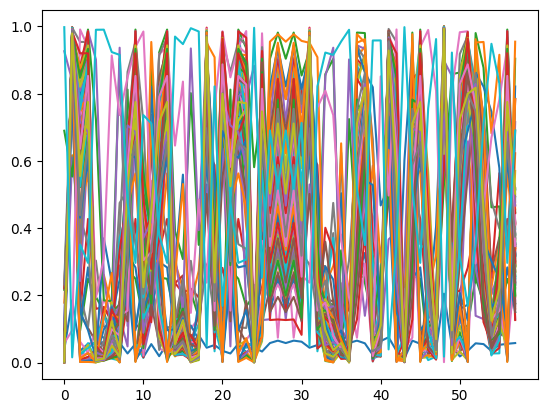

In [29]:
# _ = log.plot()
# log.to_pandas().val_loss.min()
# model.score_in_batches(val)
surv = model.predict_hazard(x_test)
# surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.plot(surv)
plt.show()
surv

model.save_model_weights('./model_weights.txt')

,0
0.000000e+00,0.961412
1.278283e-07,0.790005
2.556566e-07,0.618998
3.834848e-07,0.482309
5.113131e-07,0.464100
...,...
1.214369e-05,0.002583
1.227152e-05,0.002564
1.239934e-05,0.002557
1.252717e-05,0.002549


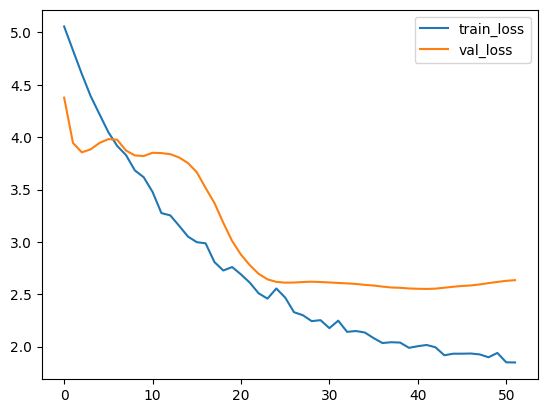

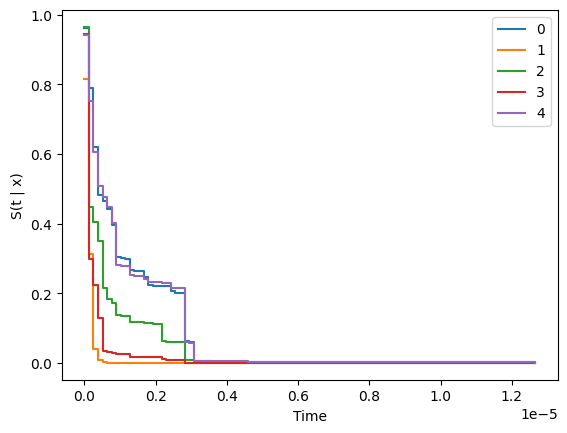

In [30]:
_ = log.plot()
log.to_pandas().val_loss.min()
model.score_in_batches(val)
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
# S(t | x) is the survival curve
# Assumption is this is the discrete data. The events they are fitting on is coming in discrete windows
# Our photo data has a consistent discretization grid in that we are checking in on the process every 30 seconds
# 
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
surv.iloc[:, :1]

- The plot below is the predicted survaval estimates of the first 5 individuals in the `x_test` dataset

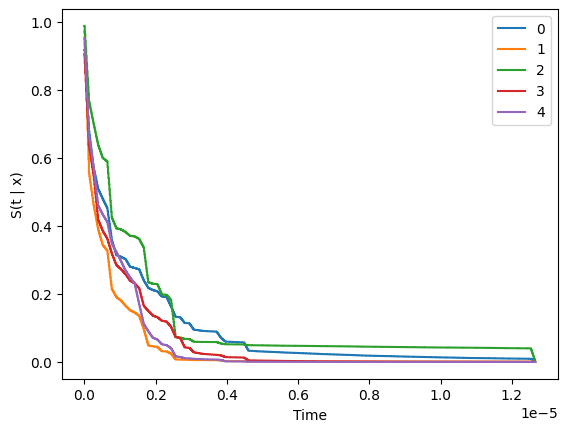

In [31]:
# TODO: Get some text output from this 
surv = model.interpolate(10).predict_surv_df(x_train)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [32]:
# ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
# ev.concordance_td('antolini')

### Getting information about model outcome


### Old Attempt for training

In [ ]:
# Extract input features and output label
x = interval_and_weather_merged[['temp', 'dwpt', 'wspd', 'coco', 'same_insect']]
y = interval_and_weather_merged[['interval', 'status']]

x = x.astype({'same_insect': 'float64'})
y = y.astype({'interval': 'float64', 'status': 'float64'})

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(y_train.head())

# TODO: Skipping the step with the DataFrameMapper function



# Transform output label
get_target = lambda df: (df['interval'].values, df['status'].values)
labtrans = LogisticHazard.label_transform(cuts=100)
y_train_trans = labtrans.fit_transform(*get_target(y_train))

y_train_trans = (np.array(y_train_trans[0], dtype='float64'), np.array(y_train_trans[1], dtype='float64'))



# labtrans.cuts
print(type(labtrans.transform(*get_target(y_val))))
print(y_train_trans[1].dtype)
# print(x_train.values.dtype)

     interval  status
262    2062.0     1.0
281     141.0     1.0
278     426.0     1.0
73       76.0     1.0
25       14.0     1.0
<class 'tuple'>
float64


In [ ]:

# Define model architecture
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

# Transform output label to `float64` for validation set
y_val_trans = labtrans.transform(*get_target(y_val))
y_val_trans = tuple(np.array(x, dtype='float64') for x in y_val_trans)
print(y_val_trans[0].dtype)
print(y_val_trans[1].dtype)
print(y_train_trans[0].dtype)
print(y_train_trans[1].dtype)
print(x_train.values.dtype)
print(x_val.values.dtype)
print(x_train.isna().sum())
print(y_train_trans.isna().sum())


# Train model
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
# Checking types 
log = model.fit(x_train.values, y_train_trans, batch_size, epochs, callbacks, val_data=(x_val.values, y_val_trans))


float64
float64
float64
float64
float64
float64
temp           0
dwpt           0
wspd           0
coco           0
same_insect    0
dtype: int64


AttributeError: 'tuple' object has no attribute 'isna'

In [ ]:
print("x_train shape:", x_train.values.shape)
print("y_train_trans[0] shape:", y_train_trans[0].shape)
print("y_train_trans[1] shape:", y_train_trans[1].shape)
print("x_val shape:", x_val.values.shape)
print("y_val_trans[0] shape:", y_val_trans[0].shape)
print("y_val_trans[1] shape:", y_val_trans[1].shape)

x_train shape: (233, 5)
y_train_trans[0] shape: (233,)
y_train_trans[1] shape: (233,)
x_val shape: (59, 5)
y_val_trans[0] shape: (59,)
y_val_trans[1] shape: (59,)


## Stacking Implimentation 
Pseudo Code
Create the predictor matrix and binary response vector for one observation/row
Okay so from the example in the Tibshirani paper what we will do for a given row of our data frame is take the `interval` value and check to see all of the other rows which interval values >= that ‘interval length
Then, we will make  a risk set with the index of our given row and all the rows that met the criteria above. 

Then, we will make our predictor matrix X(R(i)) with the covariants (temp, wspd, etc) for each row that met that hasn’t terminated yet as a row in the predictor matrix
 We then create a binary response vector \hat{y}(R(i)) 
Stack the binary response vectors
Stack the predictor matrix and add i columns for each observation in the risk set. And these column become indicator variables (1 or 0) for weather the observation corresponds to that ith member of the risk set. 
We know apply a binary classifier in order to predict the binary response vector using the predictor matrix. 
This is modeling the conditional proba of having an event at each failure time, having survived the past and previous failure times. 
TODO: Find a binary classification function and feed in our stacked predictor matrix and binary response vector. 
Statsmodels will have one. 


In [ ]:
def stack_dataframe(df):
  predictor_matrix_dfs = []
  binary_response_vector_df = []

  # iterate through each row in the dataframe
  for i, row in df.iterrows():
    # extract the 'interval' value of the current row
    current_interval = row['interval']
    print('current_interval', current_interval)
    print('index', i)
    # use boolean indexing to filter the rows where 'interval' value is greater than the current interval
    risk_set_df = df[df['interval'] >= current_interval]

    column_name = f"risk set {i}"  # set the column name variable
    predictor_df = risk_set_df.assign(**{column_name: 1}) 
    
    print('predictor_df', predictor_df)

    # add the risk_set_df dataframe to the list
    predictor_matrix_dfs.append(predictor_df)

    # create binary response vector
    current_row_predictor_matrix_index = predictor_df.index.get_loc(i)
    indicator_series = pd.Series([0] * len(risk_set_df))
    indicator_series[current_row_predictor_matrix_index] = 1

    print('indicator_series', indicator_series)
    # print('current_row', predictor_df.iloc[i])

    # add the binary response vector to the vector list 
    binary_response_vector_df.append(indicator_series)
  
  # combine predictor matrix dataframes horizontally
  stacked_predictor_df = pd.concat(predictor_matrix_dfs, axis=0)

  # combine binary response vector dataframes horizontally
  stacked_binary_response_df = pd.concat(binary_response_vector_df, axis=0)

  return stacked_predictor_df, stacked_binary_response_df
    

cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']
df_input = interval_and_weather_merged[cols_input]


stacked_predictor_df, stacked_binary_response_df = stack_dataframe(df_input)
stacked_predictor_df

# Replace NaN values with zeros for indicator columns `risk set 1`
stacked_predictor_df.fillna(0, inplace=True)

In [ ]:
stacked_binary_response_df
print(stacked_predictor_df.shape)
print(stacked_binary_response_df.shape)
print(stacked_binary_response_df.head())
stacked_predictor_df.head()


(42912, 253)
(42912,)
0    1
1    0
2    0
3    0
4    0
dtype: int64


,interval,status,temp,dwpt,wspd,coco,same_insect,risk set 0,risk set 1,risk set 2,...,risk set 288,risk set 289,risk set 290,risk set 291,risk set 292,risk set 293,risk set 294,risk set 295,risk set 296,risk set 297
0,150000000000,1,23.0,23.0,7.2,3.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1170000000000,1,23.0,23.0,7.2,3.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,660000000000,1,29.0,25.0,8.3,3.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2100000000000,1,21.0,18.9,6.0,3.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1620000000000,1,21.0,18.9,6.0,3.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Attempt at logistic regression
# TODO normalize the variables and make sure they are all the same type like what you did for pyCox
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(stacked_predictor_df, stacked_binary_response_df)
LR.predict(stacked_predictor_df.iloc[:2,:])
LR.score(stacked_predictor_df, stacked_binary_response_df)

/Users/jonah/Personal/Native-Bee-Thesis/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9921234153616704